# A PyNets Primer in Python and Bash

Docker/Singularity containers are the preferable way to run PyNets because the compute environment will include all optional dependencies, fully unlocked plotting capabilities, and will perform predictably and with fully reproducible numerical precision. To keep things simple for this demonstration, however, let's begin by just installing PyNets in a virtual environment and then run the workflow manually on some example data. The scope of this tutorial will cover single-subject workflows. For more examples (i.e. including usage with docker/singularity), see: https://pynets.readthedocs.io/en/latest/usage.html

Although we will explore the package interactively in the code that follows, bear in mind that PyNets is a *workflow*, not a library like its core dependencies (Dipy, Nilearn, Nipype, Networkx). Thus, demonstrating its usage is fundamentally a command-line endeavor, rather than a purely pythonic one to which you may be typically accustomed. 

PyNets was intentionally designed to scale with supercomputers, but also run using just a couple cores on your local laptop. Although this tutorial is designed to explore the latter use-case, ideally the user will also have (or acquire) **systems-level** thinking (an awareness of issues relevant to distributed/parallel computing) in order to make the most of what PyNets has to offer for ensemble connectome learning on your institution's HPC or using AWS batch. 

## Installation

In [50]:
%%bash
# Assuming that python3, pip, and FSL are already installed...
# Start a virtual environment and install some dependencies for our lesson.
pip install virtualenv --user
mkdir ~/virtualenvironment 2>/dev/null
virtualenv ~/virtualenvironment/pynets
cd ~/virtualenvironment/pynets/bin
source activate
./pip3 install -U gdown fury # for downloading data, running pynets, and some 3d viz
./pip3 install pynets=='0.9.998a'

Using base prefix '/usr/local/anaconda3'
New python executable in /Users/derekpisner/virtualenvironment/pynets/bin/python
Installing setuptools, pip, wheel...
done.
Requirement already up-to-date: gdown in /Users/derekpisner/virtualenvironment/pynets/lib/python3.7/site-packages (3.11.1)
Requirement already up-to-date: fury in /Users/derekpisner/virtualenvironment/pynets/lib/python3.7/site-packages (0.5.1)
  Created wheel for duecredit: filename=duecredit-0.8.0-py3-none-any.whl size=76835 sha256=383427c12606744fa66e341cbeadfe64cc1b92230e91eae1fb7b361ed8d729d9
  Stored in directory: /Users/derekpisner/Library/Caches/pip/wheels/dc/6b/30/7e7c15d43e4aeb71dbb58106356d36a290c8e276556af96e3f
  Created wheel for python-louvain: filename=python_louvain-0.13-py3-none-any.whl size=9222 sha256=f835c4442ae0011366ee4a15abaa72cf8fdcf1465e0071952e590a4d65f3fd04
  Stored in directory: /Users/derekpisner/Library/Caches/pip/wheels/dd/6b/3b/87539deabac63a68ec34be2867308907d0544e11ba4d4e728d
  Created wheel

In [51]:
%%bash
# The only GUI-based visualizer that I continue to use (personally) is fsleyes,
# which I find to be immensely intuitive, especially for fine-grained QC of overlays.
# But feel free to use an image viewer of your choice. Future PyNets versions will likely 
# include html-style reports.
# For macs, download this link for fsleyes:
wget https://fsl.fmrib.ox.ac.uk/fsldownloads/fsleyes/FSLeyes-latest-macos.tar.gz #for 2d viz
#rm -rf ~/virtualenvironment/FSLeyes.app
tar -xzvf FSLeyes-latest-macos.tar.gz -C ~/virtualenvironment
# For Linux, downnload the appropriate precompiled build from https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FSLeyes

--2020-07-07 12:24:58--  https://fsl.fmrib.ox.ac.uk/fsldownloads/fsleyes/FSLeyes-latest-macos.tar.gz
Resolving fsl.fmrib.ox.ac.uk (fsl.fmrib.ox.ac.uk)... 129.67.248.65
Connecting to fsl.fmrib.ox.ac.uk (fsl.fmrib.ox.ac.uk)|129.67.248.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 378058752 (361M) [application/x-gzip]
Saving to: ‘FSLeyes-latest-macos.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  216K 28m29s
    50K .......... .......... .......... .......... ..........  0%  420K 21m34s
   100K .......... .......... .......... .......... ..........  0% 91.6M 14m24s
   150K .......... .......... .......... .......... ..........  0%  439K 14m18s
   200K .......... .......... .......... .......... ..........  0% 43.6M 11m28s
   250K .......... .......... .......... .......... ..........  0% 30.7M 9m35s
   300K .......... .......... .......... .......... ..........  0%  439K 10m13s
   350K .......... .......... .......... ..........

# Fetch sample preprocessed data

Now we can download a minimal dataset from OASIS that includes preprocessed, multimodal fMRI and dMRI data.

*Note*: Normally, we could just use a dataset from datalad or from s3 (which will download automatically using an s3:// file path prefix if your AWS credentials are properly configured!). See `pynets_cloud` CLI , with examples here: https://pynets.readthedocs.io/en/latest/usage.html#quickstart 

In [52]:
%%bash
# Now we create an output directory for the derivatives of the pipeline (if one doesn't exist already).
if  [ -d ~/Downloads/.pynets ]; then
    rm -rf ~/Downloads/.pynets/test_oasis*
else
    mkdir ~/Downloads/.pynets
fi

# And download the data to a generic "derivatives" directory.
if  [ ! -f ~/Downloads/.pynets/test_oasis.tar.gz ]; then
    cd ~/Downloads/.pynets
    gdown https://drive.google.com/uc?id=1beEoc_Pdk6OBDYc80mBDTvUhcUny9Gu3 -O ~/Downloads/.pynets/test_oasis.tar.gz
else
    cd ~/Downloads/.pynets
fi

mkdir ~/Downloads/.pynets/derivatives/sub-OAS31172 2>/dev/null
tar -xzvf test_oasis.tar.gz -C derivatives/sub-OAS31172

Downloading...
From: https://drive.google.com/uc?id=1beEoc_Pdk6OBDYc80mBDTvUhcUny9Gu3
To: /Users/derekpisner/Downloads/.pynets/test_oasis.tar.gz
230MB [00:07, 29.4MB/s]
x ses-d0407/func/sub-OAS31172_ses-d0407_task-rest_run-01_bold.nii.gz
x ses-d0407/anat/sub-OAS31172_ses-d0407_T2w.nii.gz
x ses-d1717/dwi/sub-OAS31172_ses-d1717_run-02_dwi.bval
x ses-d1717/swi/sub-OAS31172_ses-d1717_part-phase_GRE.json
x ses-d0407/anat/sub-OAS31172_ses-d0407_acq-TSE_T2w.json
x ses-d1717/dwi/sub-OAS31172_ses-d1717_run-02_dwi.bvec
x ses-d1717/swi/sub-OAS31172_ses-d1717_minIP.json
x ses-d1717/swi/sub-OAS31172_ses-d1717_swi.nii.gz
x ses-d1717/dataset_description.json
x ses-d0407/func/sub-OAS31172_ses-d0407_task-rest_run-02_bold.json
x ses-d1717/dwi/sub-OAS31172_ses-d1717_run-01_dwi.bval
x ses-d1717/swi/sub-OAS31172_ses-d1717_part-mag_GRE.nii.gz
x ses-d1717/dwi/sub-OAS31172_ses-d1717_run-01_dwi.bvec
x ses-d1717/func/sub-OAS31172_ses-d1717_task-rest_run-01_bold.json
x ses-d1717/anat/sub-OAS31172_ses-d1717_T2sta

Now we construct a command-line call for a single subject from the data we just downloaded. We can do this in two ways -- (1) using the `pynets_bids` API since our sample data is in BIDS format and can be queried using pybids; (2) with the `pynets` API for comparison.
So, for run 1 of session d0407 from subject OAS31172, lets sample an ensemble of 144 functional connectome estimates (1 models x 6 thresholds x 2 smoothing values x 2 high-pass filter thresholds x 3 atlases x 2 time-series extraction methods).

In [ ]:
%%bash
%%capture

# Get the absolute paths to files and directories we will use. The CLI's in PyNets do NOT accept relative paths.
dir=~/Downloads/.pynets
abs_dir=`echo "$(dirname $dir)"`

# BIDS way using a pre-configured .json file that specifies how we want the pipeline to run.
# We can view this file to get an idea of what it contains:
cat ~/virtualenvironment/pynets/lib/python3.7/site-packages/pynets/config/bids_config_bold.json

# Next we initiate the `pynets_bids` CLI (note the inclusion of a run_label since the BOLD acquisitions for this dataset contain two runs):
~/virtualenvironment/pynets/bin/pynets_bids "$abs_dir"/.pynets/derivatives "$abs_dir"/.pynets/outputs participant func --participant_label OAS31172 --session_label d0407 --run_label 1 -config ~/virtualenvironment/pynets/lib/python3.7/site-packages/pynets/config/bids_config_bold.json

# *Note that the configuration in `bids_config_bold.json` is equivalent to running the following (non-BIDS) CLI call that does not require a config file:
#~/virtualenvironment/pynets/bin/pynets "$abs_dir"/.pynets/outputs -id OAS31172_d0407_1 -mod 'partcorr' -min_thr 0.20 -max_thr 0.80 -step_thr 0.10 -sm 0 4 -hp 0 0.028 -a 'BrainnetomeAtlasFan2016' 'atlas_harvard_oxford' 'destrieux2009_rois' -es 'mean' 'variance' -anat "$abs_dir"/.pynets/derivatives/sub-OAS31172/ses-d0407/anat/sub-OAS31172_ses-d0407_run-01_T1w.nii.gz -func "$abs_dir"/.pynets/derivatives/sub-OAS31172/ses-d0407/func/sub-OAS31172_ses-d0407_task-rest_run-01_bold.nii.gz -plug 'MultiProc' -work '/tmp/pynets_work' -mst -plt -embed

# Viewing outputs

In [ ]:
%%bash
cd ~/Downloads/.pynets/outputs/sub-OAS31172/ses-d0407/func
ls

tree

Lets do a bit of quality-control to ensure, for example, that the inverse warping of the destrieux2009_rois atlas from template-space to native T1w anatomical space is valid.

In [10]:
%%bash
t1w_image=`ls /tmp/pynets_work/*/*/meta_wf_*/fmri_connectometry*/register_node/reg/imgs/*t1w_brain.nii.gz | head -1`
atlas_in_t1w_image=`ls /tmp/pynets_work/*_wf_single_subject_fmri*/wf_single_*/meta_wf_*/fmri_connectometry_*/_atlas_destrieux2009_rois/register_atlas_node/atlas_destrieux2009_rois/*_gm.nii.gz | head -1`

~/virtualenvironment/FSLeyes.app/Contents/*/fsleyes "$t1w_image" "$atlas_in_t1w_image" -cm 'random' &


/Users/derekpisner/virtualenvironment/FSLeyes.app/Contents/Resources/lib/python36.zip/fsleyes/__init__.py:252: MatplotlibDeprecationWarning: 
The MATPLOTLIBDATA environment variable was deprecated in Matplotlib 3.1 and will be removed in 3.3.


The below multiplot depicts distributions of average graph topological metrics, calculated using Area-Under-the-Curve (AUC) across our window of multiple thresholds, for the ensemble of 144 connectomes sampled. As you can visually discern, topology varies considerably across estimates.

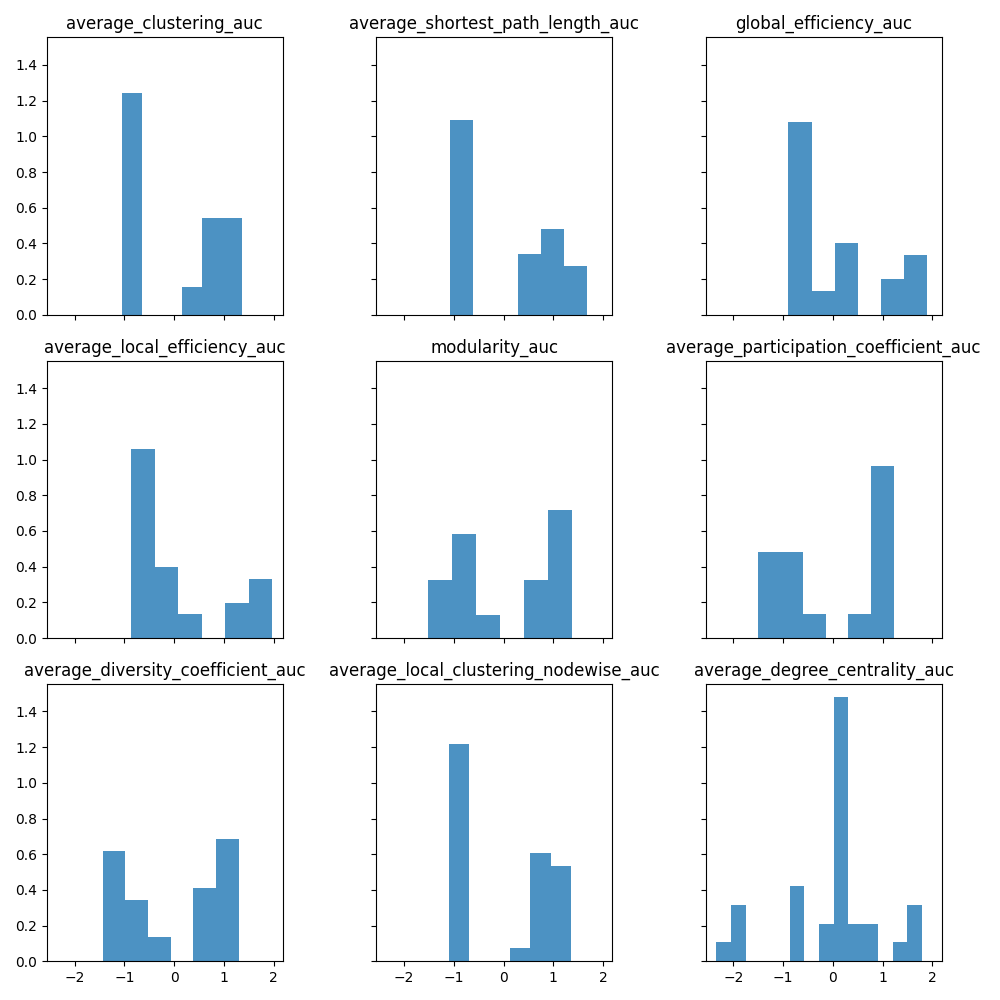

In [2]:
import glob
from IPython.display import Image
Image(filename=glob.glob('/Users/*/Downloads/.pynets/outputs/sub-OAS31172/ses-d0407/func/mean_global_topology_distribution_multiplot.png')[0])


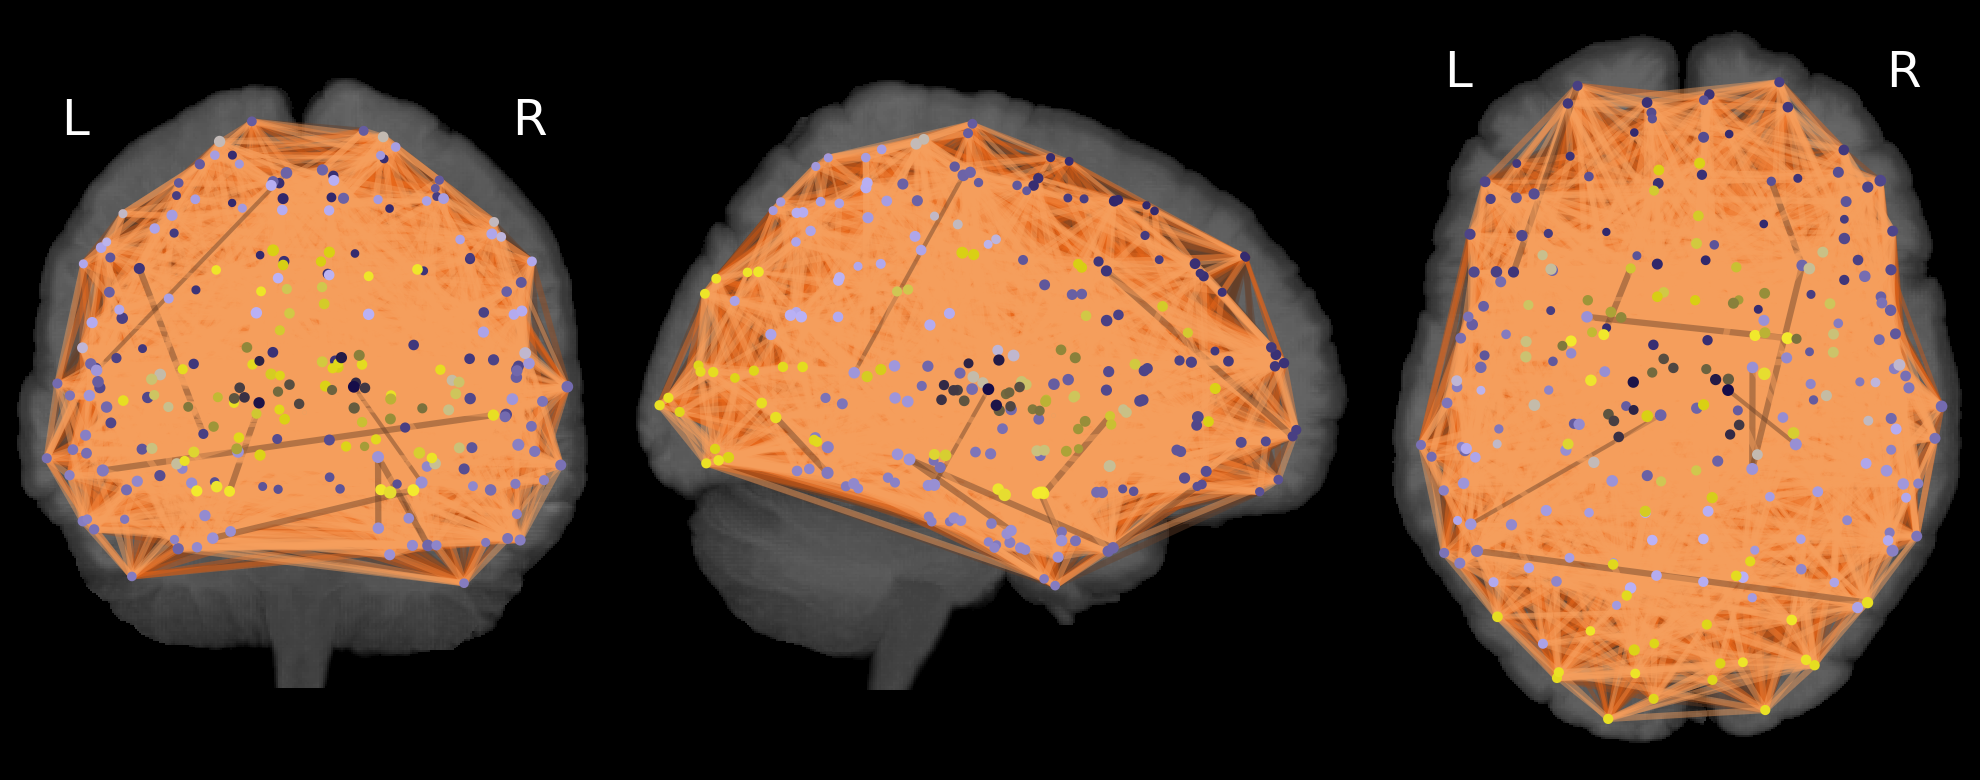

In [47]:
from IPython.display import Image
Image(filename=glob.glob('/Users/*/Downloads/.pynets/outputs/sub-OAS31172/ses-d0407/func/BrainnetomeAtlasFan2016/figures/OAS31172_d0407_1_modality-func_est-partcorr_nodetype-parc_smooth-4fwhm_hpass-0.028Hz_extract-mean_thr-0.2_glass_viz.png')[0])

Above is a glass brain depiction of left hemisphere regions of the Brainnetome atlas (Fan et al., 2016) using a partial correlation estimator, 4 fwhm smoothing, 0.028Hz high-pass filter, based on variance of the node-extracted time-series, with 20% post-hoc thresholding using the Minimum-Spanning Tree (MST) method. The latter method serves as an anti-fragmentation device that ensures we can prevent isolated (i.e. disconnected) nodes that can violate certain graph theoretical assumptions.

In the visualization, node size conveys the level of node importance (smaller is lower eigenvector centrality) and node color corresponds to hierarchical Louvain community affiliation (5 distinct communities found).

The below adjacency matrix depicts a single connectome estimate, with community affiliation. 

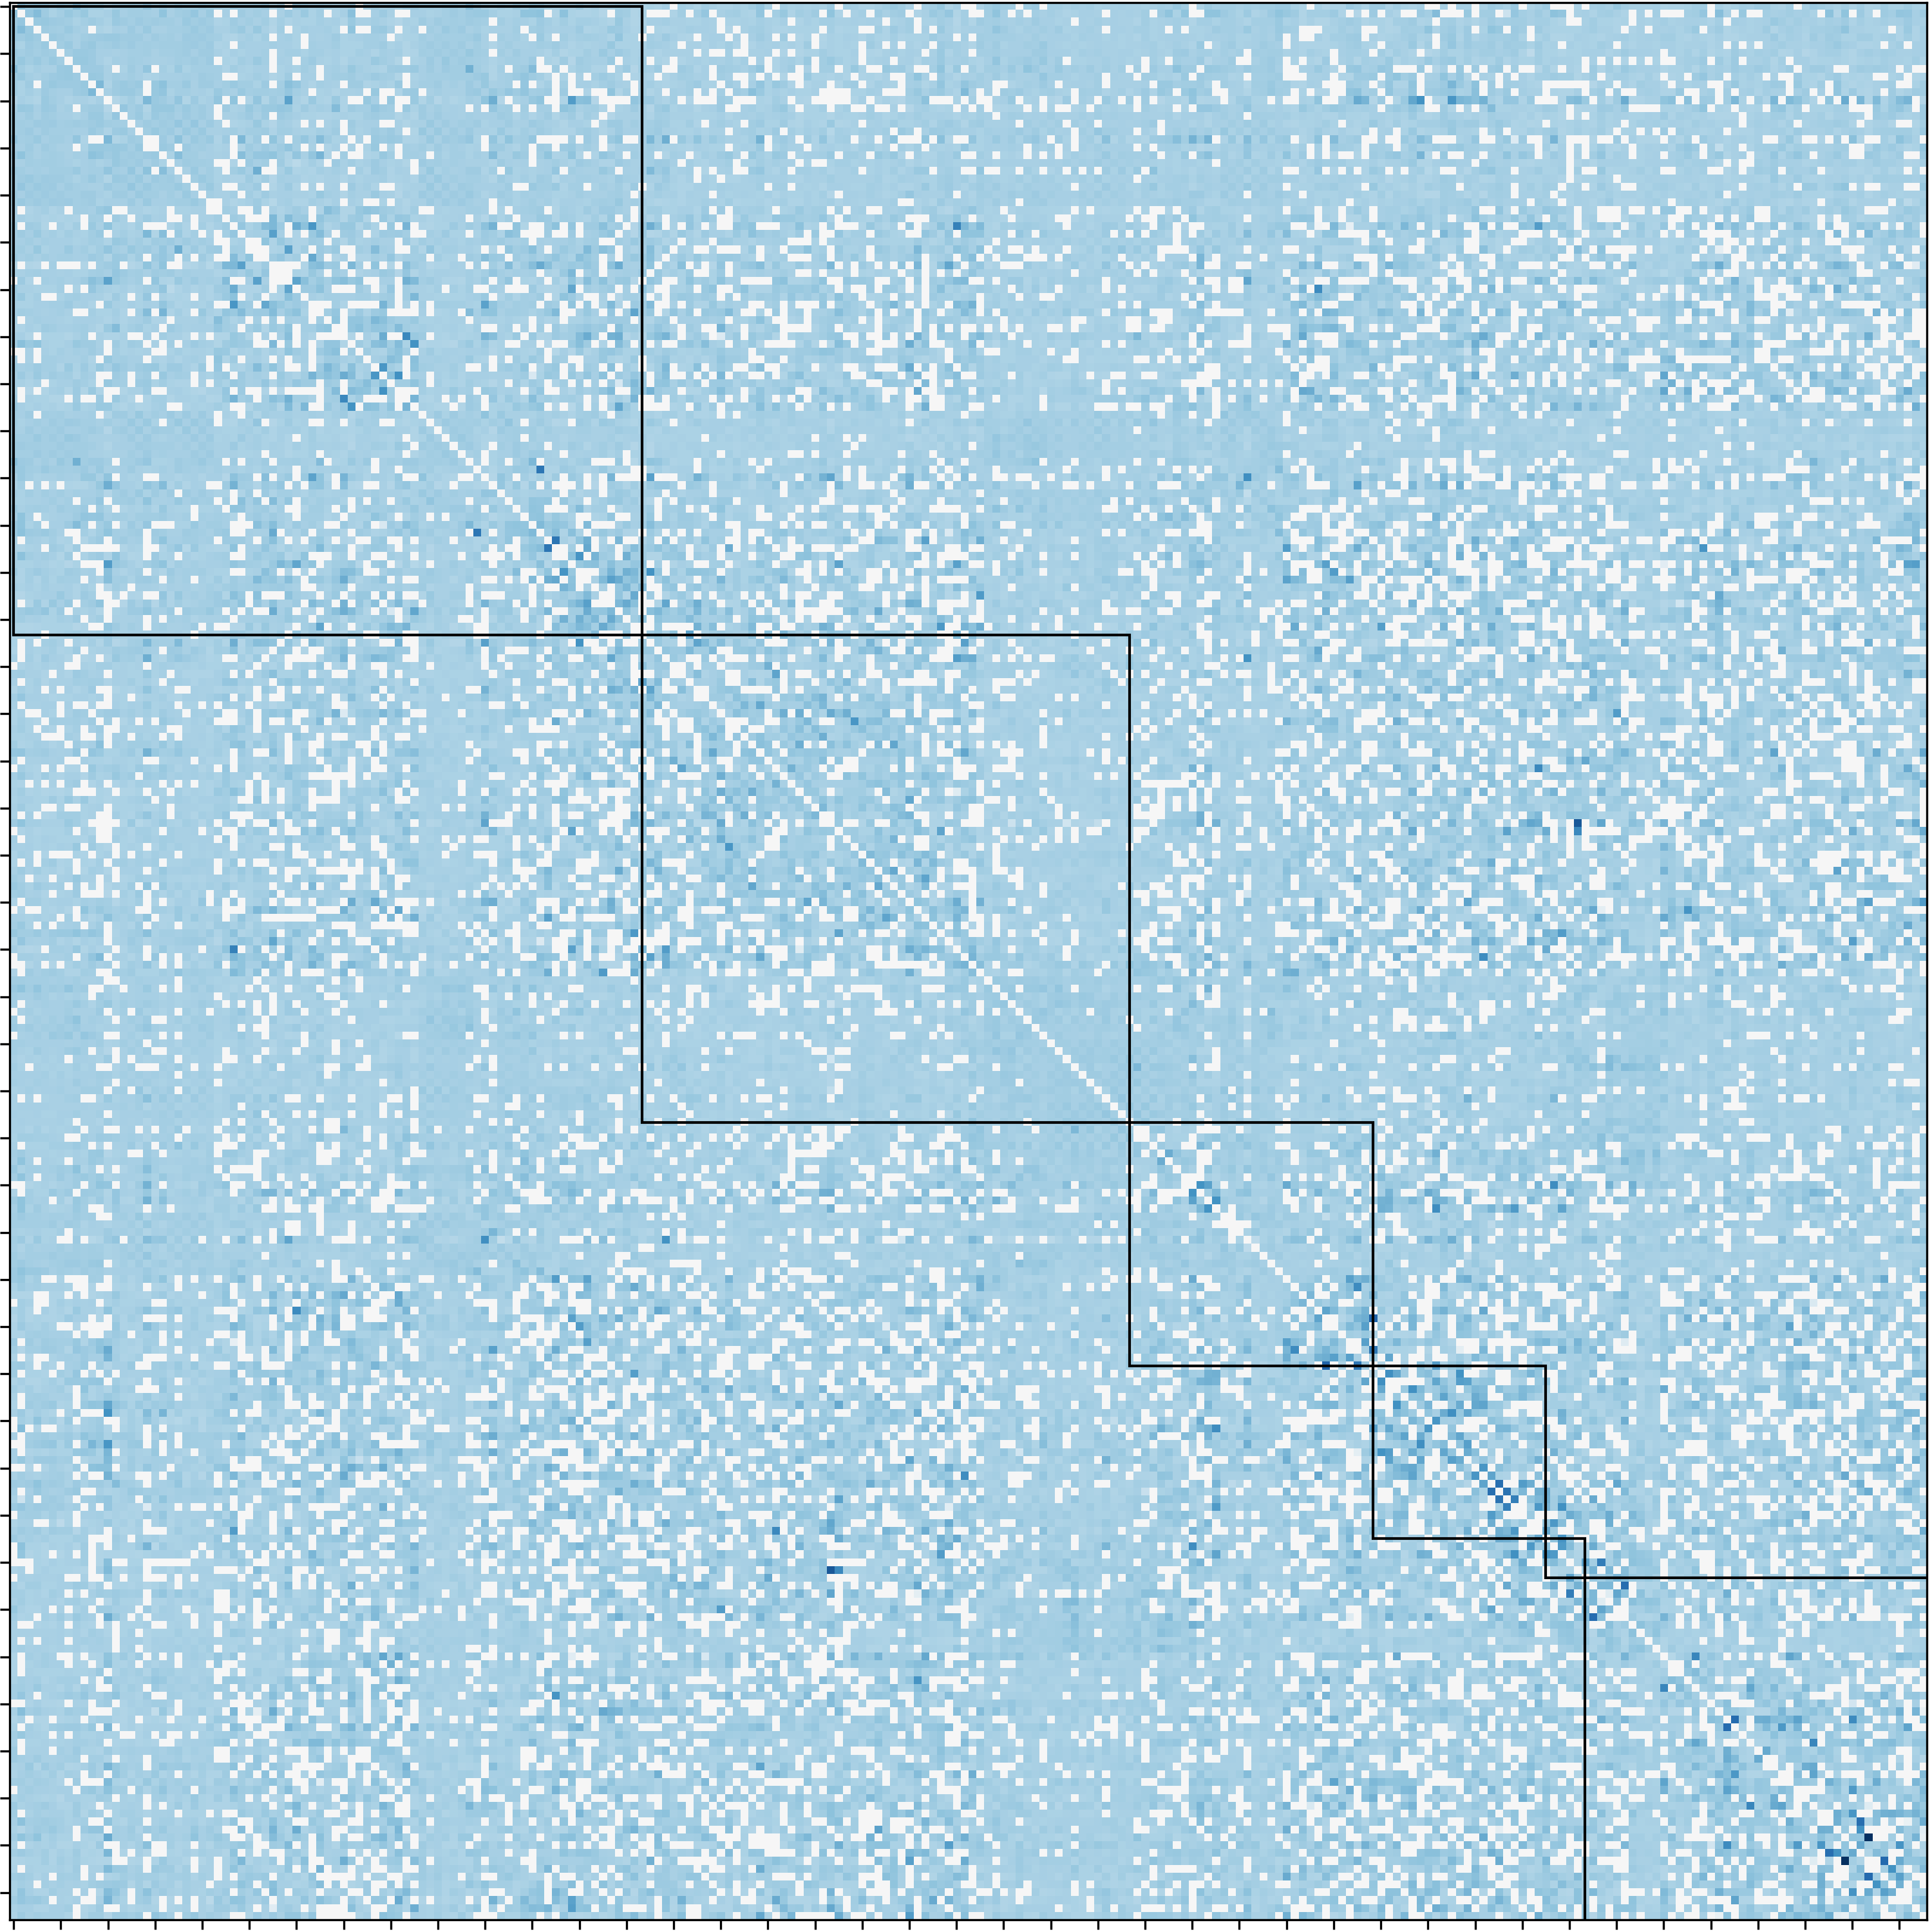

In [4]:
Image(filename=glob.glob('/Users/*/Downloads/.pynets/outputs/sub-OAS31172/ses-d0407/func/BrainnetomeAtlasFan2016/figures/OAS31172_d0407_1_modality-func_est-partcorr_nodetype-parc_smooth-4fwhm_extract-variance_thr-0.8_adj_mat_comm.png')[0])


We could also look at the mean connectome (i.e. across all 144 estimates) -- what we might from here on out refer to as an **omnetome** as well:

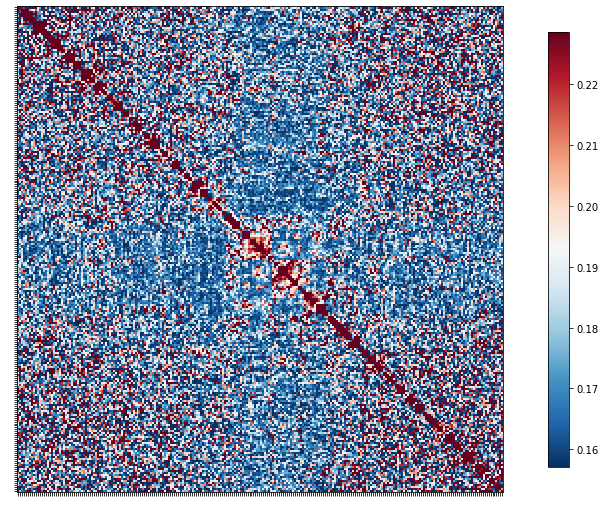

In [15]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
from nilearn.plotting import plot_matrix
from pynets.core.thresholding import standardize

mats = [np.load(i) for i in glob.glob('/Users/*/Downloads/.pynets/outputs/sub-OAS31172/ses-d0407/func/BrainnetomeAtlasFan2016/graphs/*.npy')]

mean_mat = standardize(np.mean([mat for mat in mats if mat.shape==(244,244)], axis=0))

plot_matrix(
    mean_mat,
    figure=(10, 10),
    labels=[' ']*len(mean_mat),
    vmax=np.percentile(mean_mat[mean_mat > 0], 90),
    vmin=np.percentile(mean_mat[mean_mat > 0], 10),
    reorder="average",
    auto_fit=True,
    grid=False,
    colorbar=True,
    cmap='RdBu_r',
)
plt.show()

As you can see, we get a much more information-rich graph. This graph, unlike the first, now represents a new *distribution* of connectomes, that, by virtue of its plurality of views, more exhaustively samples from the true *population* of networks in this individual that may exhibit connectivity, across the whole brain as a region of interest, at any point in time during the course of the 5-10 minute resting-state time-series.

# Collecting Outputs
So, we explored the outputs of our connectome ensemble visually, but let's take a closer look at our omnetome's topology. To do this, we run another workflow using the `pynets_collect` CLI, which collects the various graph topological metrics extracted from each of the connectome point estimates in our ensemble.

In [23]:
%%bash

dir=~/Downloads/.pynets
abs_dir=`echo "$(dirname $dir)"`
pynets_collect -basedir "$abs_dir"/.pynets/outputs -modality 'func'



PyNets Version:
0.9.997d


200706-22:27:49,434 nipype.workflow INFO:
	 Generated workflow graph: /tmp/work/pynets_out_collection/load_pd_dfs/graph.png (graph2use=colored, simple_form=True).

Running with {'n_procs': 4, 'memory_gb': 8, 'scheduler': 'mem_thread'}

200706-22:27:50,362 nipype.workflow INFO:
	 Workflow load_pd_dfs settings: ['check', 'execution', 'logging', 'monitoring']
200706-22:27:50,371 nipype.workflow INFO:
	 Running in parallel.
200706-22:27:50,373 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 8.00/8.00, Free processors: 4/4.
200706-22:27:51,374 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 7.80/8.00, Free processors: 3/4.
                     Currently running:
                       * load_pd_dfs.build_subject_dict_node
200706-22:27:52,383 nipype.workflow INFO:
	 [Node] Setting-up "load_pd_dfs.build_subject_dict_node" in "/private/tmp/work/pynets_out_collection/load_pd_dfs/_sub_s

In [20]:
import pathlib
from pathlib import Path
import pandas as pd

# Now we can load a dataframe of summary topological graph metrics for the run for this particular subject.
# Note that if we were to sample connectomes from multiple subjects, the previous pynets_collect CLI would
# simply append new rows to the dataframe per subject run.
p = str(Path('~').expanduser()) + '/Downloads/.pynets/outputs/all_subs_neat.csv'
df = pd.read_csv(p, index_col=False)
df

id  \
0  sub-OAS31172_ses-d0407   

   BrainnetomeAtlasFan2016_corr_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST__net_mets_auc_average_betweenness_centrality_auc  \
0                                            0.00417                                                                                    

   BrainnetomeAtlasFan2016_corr_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST__net_mets_auc_average_clustering_auc  \
0                                           0.338546                                                                        

   BrainnetomeAtlasFan2016_corr_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST__net_mets_auc_average_degree_centrality_auc  \
0                                           0.199253                                                                               

   BrainnetomeAtlasFan2016_corr_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST__net_mets_auc_average_diversity_coefficient_auc  \
0                                           0.423061                                                                                   

   BrainnetomeAtlasFan2016_corr_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST__net_mets_auc_average_eigenvector_centrality_auc  \
0                                           0.057475                                                                                    

   BrainnetomeAtlasFan2016_corr_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST__net_mets_auc_average_local_clustering_nodewise_auc  \
0                                           0.538298                                                                                       

   BrainnetomeAtlasFan2016_corr_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST__net_mets_auc_average_local_efficiency_auc  \
0                                           1.523333                                                                              

   BrainnetomeAtlasFan2016_corr_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST__net_mets_auc_average_participation_coefficient_auc  \
0                                           0.348434                                                                                       

   BrainnetomeAtlasFan2016_corr_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST__net_mets_auc_average_shortest_path_length_auc  \
0                                           0.776377                                                                                  

   ...  \
0  ...   

   DesikanKlein2012_partcorr_nodetype-parc_smooth-4fwhm_hpass-0Hz_extract-variance_thrtype-MST__net_mets_auc_average_clustering_auc  \
0                                           0.053335                                                                                  

   DesikanKlein2012_partcorr_nodetype-parc_smooth-4fwhm_hpass-0Hz_extract-variance_thrtype-MST__net_mets_auc_average_degree_centrality_auc  \
0                                           0.199725                                                                                         

   DesikanKlein2012_partcorr_nodetype-parc_smooth-4fwhm_hpass-0Hz_extract-variance_thrtype-MST__net_mets_auc_average_diversity_coefficient_auc  \
0                                           0.753636                                                                                             

   DesikanKlein2012_partcorr_nodetype-parc_smooth-4fwhm_hpass-0Hz_extract-variance_thrtype-MST__net_mets_auc_average_eigenvector_centrality_auc  \
0                                           0.100238                                                                                              

   DesikanKlein2012_partcorr_nodetype-parc_smooth-4fwhm_hpass-0Hz_extract-variance_thrtype-MST__net_mets_auc_average_local_clustering_nodewise_auc  \
0                                            0.23935                                                                                                 

   DesikanKlein2012_partcorr_nodetype-parc_smooth-4fwhm_hpass-0

# Structural Connectometry

And now we construct a command-line call for the same subject, but using their dMRI data instead. This time, we should ideally use a higher voxel resolution (1mm) since we are working with microstructure data, but this would increase runtime by as much as 50%, which would be better saved for HPC environments. For demonstration purposes, we will therefore downsample our data slightly and work in 2mm voxel resolution.

So, for run 1 of session d0407 from subject OAS31172, lets sample an ensemble of 72 structural connectome estimates (1 diffusion model type x 6 thresholds x 2 direction-getting methods x 2 minimum streamline length thresholds x 3 atlases.

In [ ]:
%%bash
%%capture

# Again, get the absolute paths to files and directories we will use.
# The CLI's in PyNets do NOT accept relative paths.
dir=~/Downloads/.pynets
abs_dir=`echo "$(dirname $dir)"`

# BIDS way using a pre-configured .json file that specifies how we want the pipeline to run.
# We can view this file to get an idea of what it contains:
cat ~/virtualenvironment/pynets/lib/python3.7/site-packages/pynets/config/bids_config_dwi.json

# Next we initiate the `pynets_bids` CLI:
~/virtualenvironment/pynets/bin/pynets_bids "$abs_dir"/.pynets/derivatives "$abs_dir"/.pynets/outputs participant dwi --participant_label OAS31172 --session_label d0407 -config ~/virtualenvironment/pynets/lib/python3.7/site-packages/pynets/config/bids_config_dwi.json

# *Note that the configuration in `bids_config_dwi.json` is equivalent to running the following (non-BIDS) CLI call that does not require a config file:
#~/virtualenvironment/pynets/bin/pynets "$abs_dir"/.pynets/outputs -mod 'csa' -min_thr 0.20 -max_thr 0.80 -step_thr 0.10 -dg 'det' 'prob' -ml 20 0 -a 'BrainnetomeAtlasFan2016' 'atlas_harvard_oxford' 'destrieux2009_rois' -anat ""$abs_dir"/.pynets/derivatives/sub-OAS31172/ses-d0407/anat/sub-OAS31172_ses-d0407_run-01_T1w.nii.gz" -dwi ""$abs_dir"/.pynets/derivatives/sub-OAS31172/ses-d0407/dwi/sub-OAS31172_ses-d0407_dwi.nii.gz" -bval ""$abs_dir"/.pynets/derivatives/sub-OAS31172/ses-d0407/dwi/sub-OAS31172_ses-d0407_dwi.bval" -bvec ""$abs_dir"/.pynets/derivatives/sub-OAS31172/ses-d0407/dwi/sub-OAS31172_ses-d0407_dwi.bvec" -id OAS31172_d0407_1 -plug 'MultiProc' -work '/tmp/pynets_work' -mst -plt -vox '2mm' -embed


# Viewing outputs

In [17]:
%%bash
cd ~/Downloads/.pynets/outputs/sub-OAS31172/ses-d0407/dwi
ls .
tree

BrainnetomeAtlasFan2016
DesikanKlein2012
atlas_harvard_oxford
destrieux2009_rois
reg
sub-OAS31172_ses-d0407_dwi_bvecs_reor.bvec
sub-colin27_label-L2018_desc-scale1_atlas
sub-colin27_label-L2018_desc-scale2_atlas
sub-colin27_label-L2018_desc-scale3_atlas
sub-colin27_label-L2018_desc-scale4_atlas
sub-colin27_label-L2018_desc-scale5_atlas
summary
t1w_brain_mask.nii.gz
.
├── BrainnetomeAtlasFan2016
│   ├── BrainnetomeAtlasFan2016_tmp_reor-RAS_res-1mm.nii.gz
│   ├── BrainnetomeAtlasFan2016_tmp_reor-RAS_res-2mm.nii.gz
│   ├── embeddings
│   │   ├── O_BrainnetomeAtlasFan2016_whole_brain_asetome.npy
│   │   ├── O_BrainnetomeAtlasFan2016_whole_brain_asetome_estimator.joblib
│   │   ├── O_BrainnetomeAtlasFan2016_whole_brain_masetome_estimator_mds.joblib
│   │   ├── O_BrainnetomeAtlasFan2016_whole_brain_masetome_estimator_omni.joblib
│   │   ├── O_BrainnetomeAtlasFan2016_whole_brain_omnetome.npy
│   │   ├── O_DesikanKlein2012_whole_brain_masetome_estimator_mds.joblib
│   │   ├── O_DesikanKlein201

Lets do a bit of quality-control to ensure, for example, that the inverse warping of the harvard_oxford atlas from template-space to native DWI anatomical space is valid.

In [24]:
%%bash
t1w_dwi_image=`ls /tmp/pynets_work/*/*/meta_wf_*/dmri_connectometry*/register_node/dmri_reg/reg/imgs/t1w_in_dwi.nii.gz | head -1`
atlas_in_t1w_dwi_image=`ls /tmp/pynets_work/*_wf_single_subject_dmri*/wf_single_*/meta_wf_*/dmri_connectometry_*/*/register_atlas_node/atlas_atlas_harvard_oxford/atlas_harvard_oxford_dwi_track.nii.gz | head -1`
density_map=`ls ~/Downloads/.pynets/outputs/sub-OAS31172/ses-d0407/dwi/atlas_harvard_oxford/tractography/*.nii.gz | head -1`

~/virtualenvironment/FSLeyes.app/Contents/*/fsleyes "$t1w_dwi_image" "$atlas_in_t1w_dwi_image" -cm 'random' "$density_map" &

ls: /tmp/pynets_work/*_wf_single_subject_dmri*/wf_single_*/meta_wf_*/dmri_connectometry_*/_atlas_atlas_harvard_oxford/register_atlas_node/atlas_atlas_harvard_oxford/atlas_harvard_oxford_dwi_track.nii.gz: No such file or directory
ls: /Users/derekpisner/Downloads/.pynets/outputs/sub-OAS31172/ses-d0407/dwi/atlas_harvard_oxford/tractography/*.nii.gz: No such file or directory
Error loading command line arguments: An error occurred loading the command-line arguments.


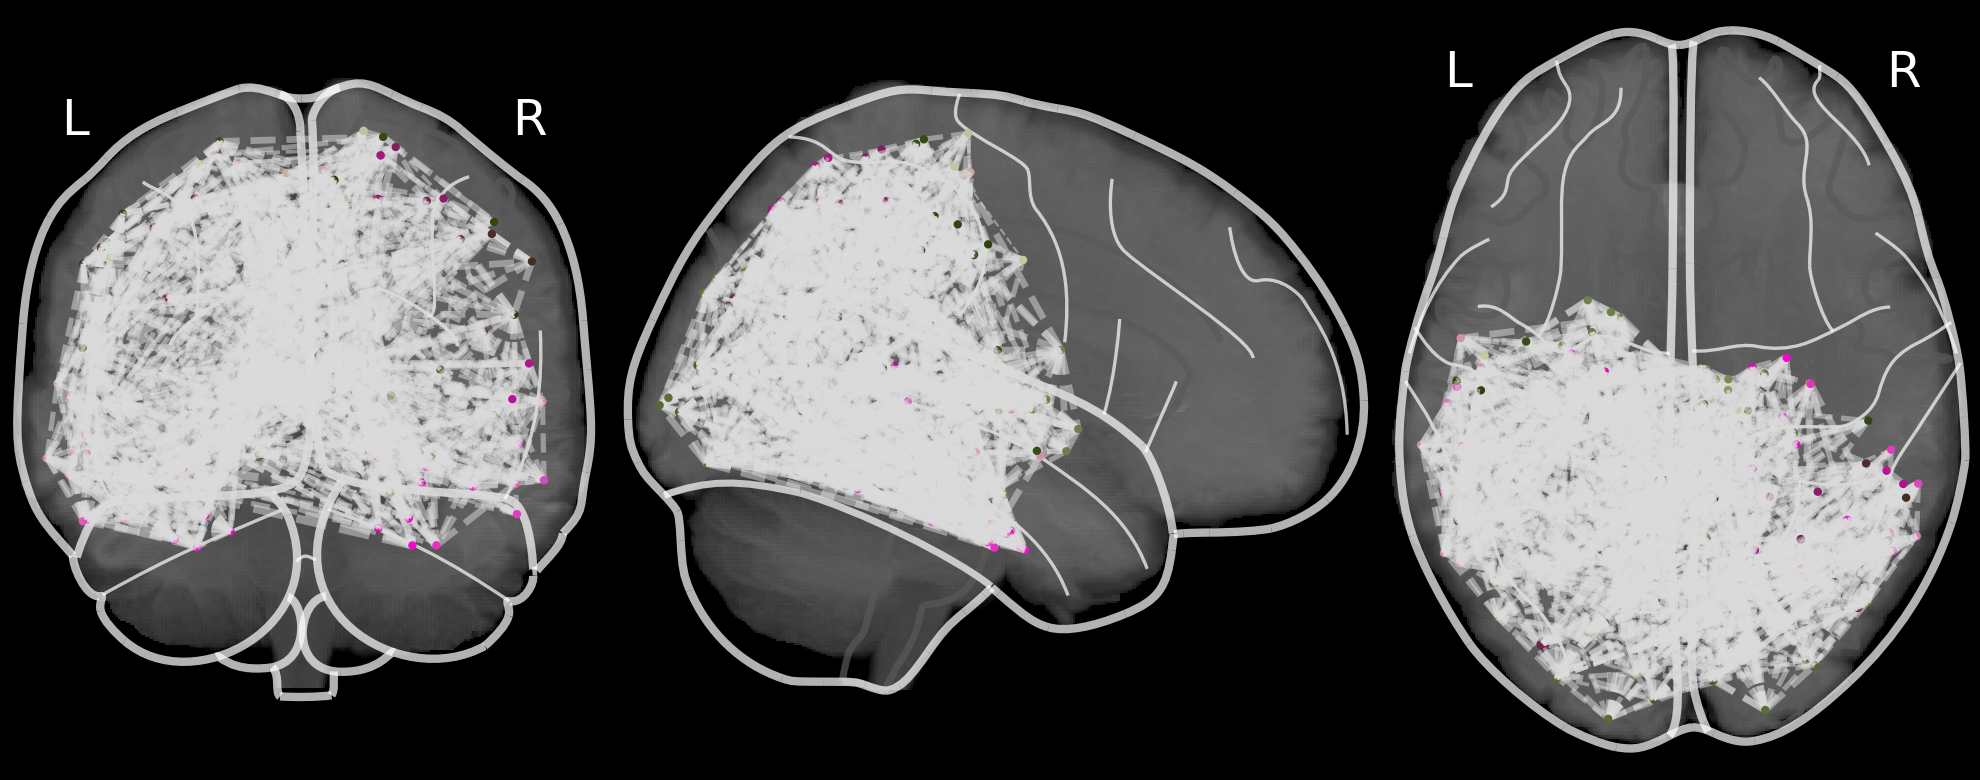

In [26]:
import glob
from IPython.display import Image
Image(filename=glob.glob('/Users/*/Downloads/.pynets/outputs/sub-OAS31172/ses-d0407/dwi/BrainnetomeAtlasFan2016/figures/OAS31172_d0407_modality-dwi_est-csa_nodetype-parc_samples-50000streams_tt-local_dg-det_ml-20_thr-0.2_glass_viz.png')[0])

Above is a glass brain depiction of regions of the Desikan Klein 2012 atlas using a tensor model estimator of diffusion, deterministic tractography, a minimum fiber length threshold of 20, with 80% post-hoc thresholding using the Minimum-Spanning Tree (MST) method.
Again, un the visualization, node size conveys the level of node importance (smaller is lower eigenvector centrality) and node color corresponds to hierarchical Louvain community affiliation (only two distinct communities found). Unlike in the functional case, however, edges are here depicted with dotted white lines to differentiate them from functional edges, which carry a different meaning.

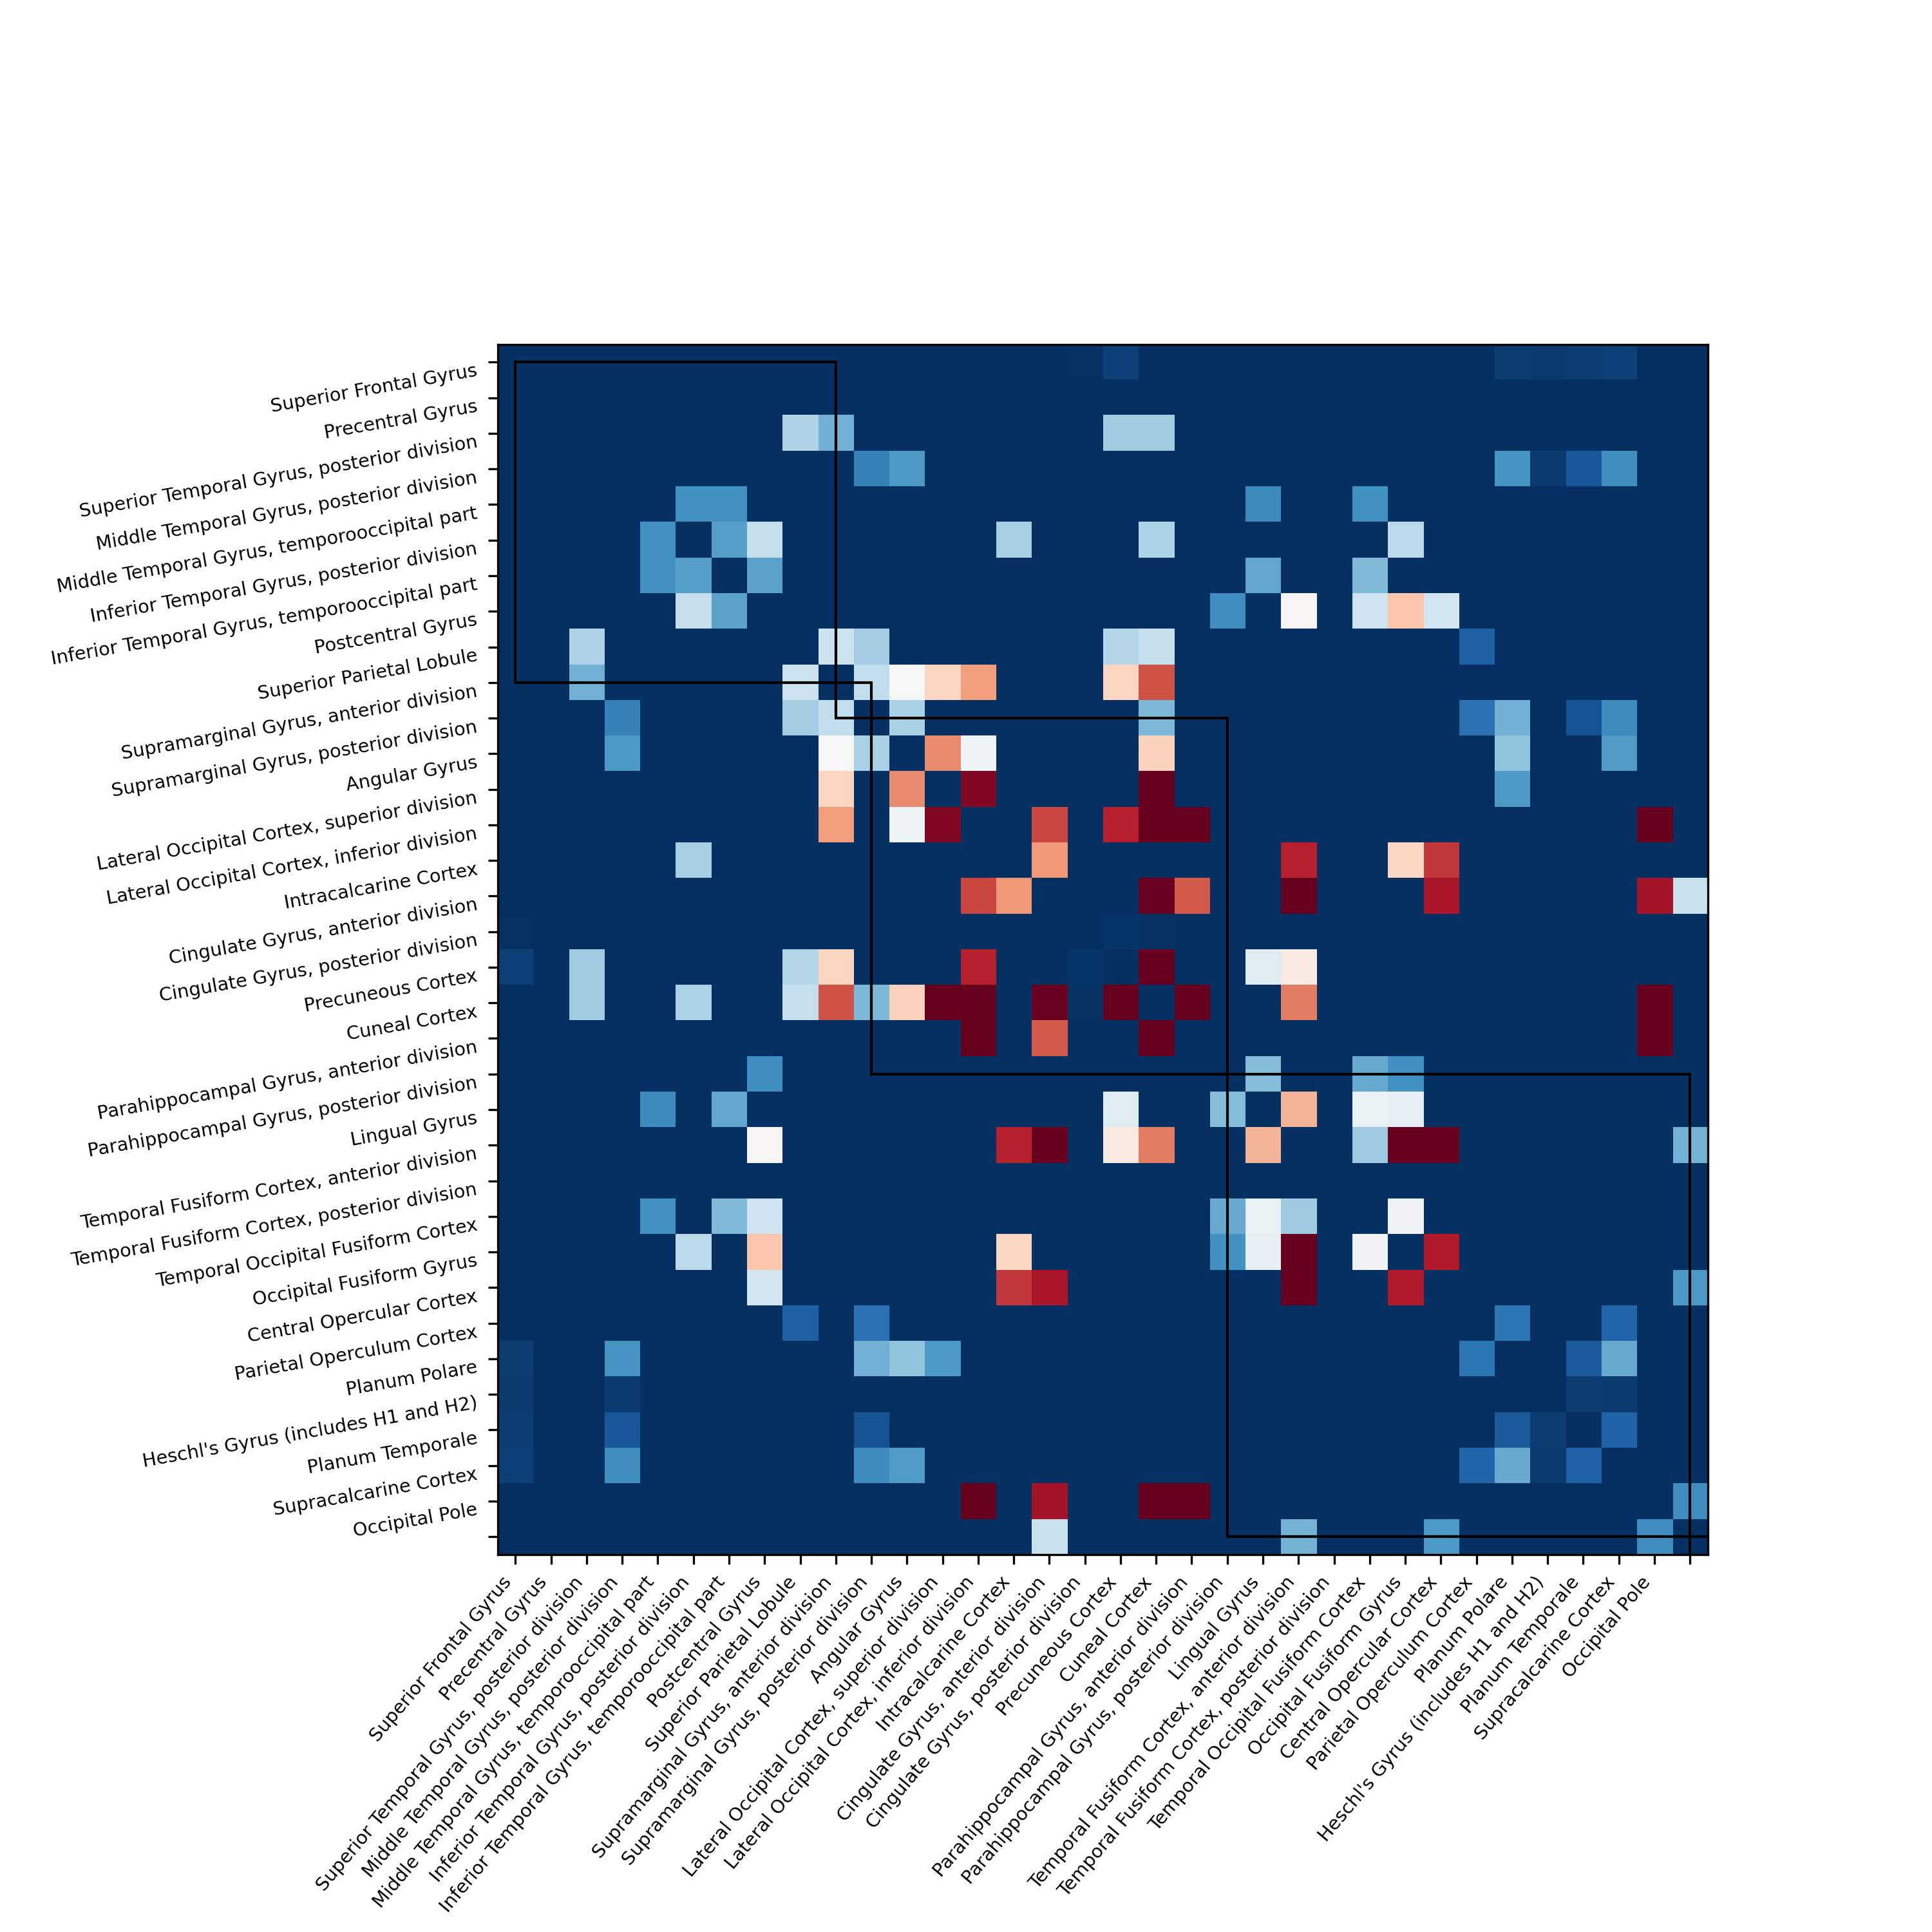

In [29]:
Image(filename=glob.glob('/Users/*/Downloads/.pynets/outputs/sub-OAS31172/ses-d0407/dwi/atlas_harvard_oxford/figures/OAS31172_d0407_modality-dwi_est-csa_nodetype-parc_samples-50000streams_tt-local_dg-det_ml-20_thr-0.2_adj_mat_comm.png')[0])

The above adjacency matrix depicts a single connectome estimate, with community affiliation. But we could also look at a structural omnetome (i.e. based on FA-weighted fiber counts) across all 72 independent connectome estimations. Note that by default pynets only samples 50,000 streamlines whose endpoints intersect with at least two parcellation regions after all tissue/waymask/minimum-length filtering. This keeps runtimes down to <60 minutes for the complete structural connectometry pipeline. Bear in mind, however, that across our ensemble sample, we are **actually** sampling 50,000 x 72 = 3.6 million streamlines! And since we are further employing ensemble tractography, which samples across 5 step sizes (0.1, 0.2, 0.3, 0.4, 0.5) and 2 curvature thresholds (30, 40) by default, we are actually indirectly sampling across a much wider grid of parameters still.

Whereas in the functional connectometry case, we examined the mean connectome across estimates, here we might choose to examine the max connectome specifically, since structural connectomes are inherently sparser.

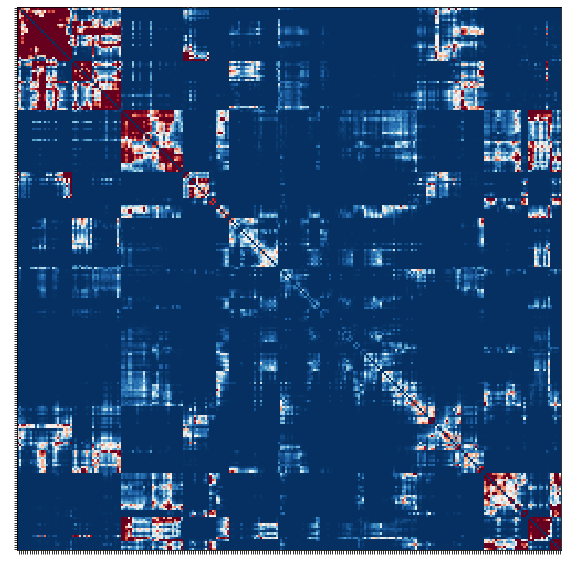

In [42]:
import pickle
import glob
import numpy as np
from matplotlib import pyplot as plt
from nilearn.plotting import plot_matrix
from pynets.core.thresholding import standardize

mats = [np.load(i) for i in glob.glob('/Users/*/Downloads/.pynets/outputs/sub-OAS31172/ses-d0407/dwi/BrainnetomeAtlasFan2016/graphs/*.npy')]

max_mat = standardize(np.max([mat for mat in mats if mat.shape==(246,246)], axis=0))


plot_matrix(
    max_mat,
    figure=(10, 10),
    labels=[' ']*len(max_mat),
    vmax=np.percentile(max_mat[max_mat > 0], 95),
    vmin=np.percentile(max_mat[max_mat > 0], 10),
    reorder="average",
    auto_fit=True,
    grid=False,
    colorbar=False,
    cmap='RdBu_r',
)
plt.show()

As you can see, we get a much more information-rich graph. This graph, unlike the first, now represents a new *distribution* of connectomes, that, by virtue of its plurality of views, more exhaustively samples from the true *population* of networks in this individual that may exhibit connectivity, across the whole brain as a region of interest.

# Collecting Outputs
Now, we explored the outputs of our connectome ensemble visually, but let's take a closer look at the actual topological data. To do this, we run another workflow using the `pynets_collect` CLI.

In [43]:
%%bash

dir=~/Downloads/.pynets
abs_dir=`echo "$(dirname $dir)"`
pynets_collect -basedir "$abs_dir"/.pynets/outputs -modality 'dwi'



PyNets Version:
0.9.998


200707-10:15:06,231 nipype.workflow INFO:
	 Generated workflow graph: /tmp/work/pynets_out_collection/load_pd_dfs/graph.png (graph2use=colored, simple_form=True).

Running with {'n_procs': 4, 'memory_gb': 8, 'scheduler': 'mem_thread'}

200707-10:15:07,88 nipype.workflow INFO:
	 Workflow load_pd_dfs settings: ['check', 'execution', 'logging', 'monitoring']
200707-10:15:07,96 nipype.workflow INFO:
	 Running in parallel.
200707-10:15:07,98 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 8.00/8.00, Free processors: 4/4.
200707-10:15:08,99 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 7.80/8.00, Free processors: 3/4.
                     Currently running:
                       * load_pd_dfs.build_subject_dict_node
200707-10:15:09,98 nipype.workflow INFO:
	 [Node] Setting-up "load_pd_dfs.build_subject_dict_node" in "/private/tmp/work/pynets_out_collection/load_pd_dfs/_sub_sub-OAS

In [19]:
import pathlib
from pathlib import Path
import pandas as pd

# Now we can load a dataframe of summary topological graph metrics for the run for this particular subject.
# Note that if we were to sample connectomes from multiple subjects, the previous pynets_collect CLI would
# simply append new rows to the dataframe per subject run.
p = str(Path('~').expanduser()) + '/Downloads/.pynets/outputs/all_subs_neat.csv'
df = pd.read_csv(p, index_col=False)
df

id  \
0  sub-OAS31172_ses-d0407   

   BrainnetomeAtlasFan2016_corr_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST__net_mets_auc_average_betweenness_centrality_auc  \
0                                            0.00417                                                                                    

   BrainnetomeAtlasFan2016_corr_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST__net_mets_auc_average_clustering_auc  \
0                                           0.338546                                                                        

   BrainnetomeAtlasFan2016_corr_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST__net_mets_auc_average_degree_centrality_auc  \
0                                           0.199253                                                                               

   BrainnetomeAtlasFan2016_corr_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST__net_mets_auc_average_diversity_coefficient_auc  \
0                                           0.423061                                                                                   

   BrainnetomeAtlasFan2016_corr_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST__net_mets_auc_average_eigenvector_centrality_auc  \
0                                           0.057475                                                                                    

   BrainnetomeAtlasFan2016_corr_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST__net_mets_auc_average_local_clustering_nodewise_auc  \
0                                           0.538298                                                                                       

   BrainnetomeAtlasFan2016_corr_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST__net_mets_auc_average_local_efficiency_auc  \
0                                           1.523333                                                                              

   BrainnetomeAtlasFan2016_corr_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST__net_mets_auc_average_participation_coefficient_auc  \
0                                           0.348434                                                                                       

   BrainnetomeAtlasFan2016_corr_nodetype-parc_hpass-0.028Hz_extract-mean_thrtype-MST__net_mets_auc_average_shortest_path_length_auc  \
0                                           0.776377                                                                                  

   ...  \
0  ...   

   DesikanKlein2012_partcorr_nodetype-parc_smooth-4fwhm_hpass-0Hz_extract-variance_thrtype-MST__net_mets_auc_average_clustering_auc  \
0                                           0.053335                                                                                  

   DesikanKlein2012_partcorr_nodetype-parc_smooth-4fwhm_hpass-0Hz_extract-variance_thrtype-MST__net_mets_auc_average_degree_centrality_auc  \
0                                           0.199725                                                                                         

   DesikanKlein2012_partcorr_nodetype-parc_smooth-4fwhm_hpass-0Hz_extract-variance_thrtype-MST__net_mets_auc_average_diversity_coefficient_auc  \
0                                           0.753636                                                                                             

   DesikanKlein2012_partcorr_nodetype-parc_smooth-4fwhm_hpass-0Hz_extract-variance_thrtype-MST__net_mets_auc_average_eigenvector_centrality_auc  \
0                                           0.100238                                                                                              

   DesikanKlein2012_partcorr_nodetype-parc_smooth-4fwhm_hpass-0Hz_extract-variance_thrtype-MST__net_mets_auc_average_local_clustering_nodewise_auc  \
0                                            0.23935                                                                                                 

   DesikanKlein2012_partcorr_nodetype-parc_smooth-4fwhm_hpass-0

Later tutorials will cover a variety of additional topics, including how you can deploy PyNets across entire BIDS datasets in a single command-line interface (CLI) call, benchmark and optimize connectome ensembles across diverse analytic scenarios with GridSearchCV integration, along with more advanced topics such as performing and visualizing multiplex graph analysis and embeddings of multimodal connectomes.